In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

data_folder_path = "/content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/68e8d1d70b66d_student_resource/student_resource/dataset"
output_folder_path = f"{data_folder_path}/output_csv_folder"  # Removed .csv

# Check if Data is present
if not os.path.exists(data_folder_path):
    raise FileNotFoundError(f"The path {data_folder_path} does not exist.")
else:
    print("Data is present")

# Create the folder if it doesn't exist
os.makedirs(output_folder_path, exist_ok=True)
print(f"Folder created at: {output_folder_path}")

# You can then save files like this:
#csv_file_path = f"{output_folder_path}/your_data.csv"
# df.to_csv(csv_file_path)  # Example for pandas

Data is present
Folder created at: /content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/68e8d1d70b66d_student_resource/student_resource/dataset/output_csv_folder


In [3]:
from PIL import Image, ImageOps
import requests
from io import BytesIO
import pandas as pd

train = pd.read_csv(f"{data_folder_path}/train.csv")
test = pd.read_csv(f"{data_folder_path}/test.csv")
sample_test = pd.read_csv(f"{data_folder_path}/sample_test.csv")
sample_test_out = pd.read_csv(f"{data_folder_path}/sample_test_out.csv")

train.head()

,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


# Download Images

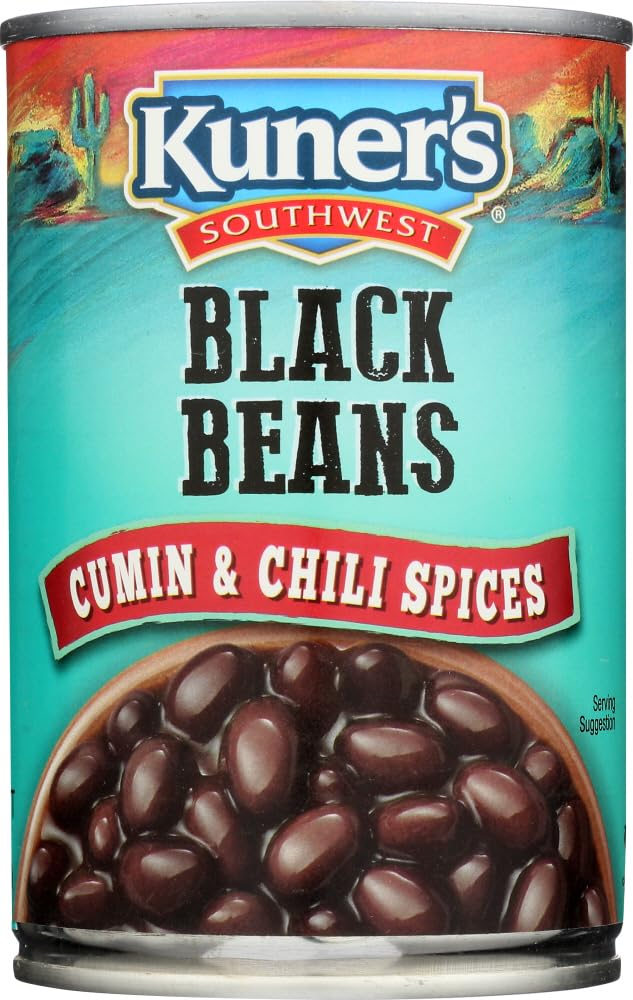

In [4]:
#Replace with your image URL
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display

image_url = train.iloc[38820]['image_link']

#Download the image
response = requests.get(image_url)
img = Image.open(BytesIO(response.content)).convert("RGB")
display(img)

In [5]:
import re

def clean_item_name(text):
    # remove "Item Name:" (case insensitive, optional leading/trailing spaces)
    text = re.sub(r'(?i)^item name:\s*', '', text.strip())
    # normalize spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

train['catalog_content'] = train['catalog_content'].apply(clean_item_name)
test['catalog_content'] = test['catalog_content'].apply(clean_item_name)
train.head()

,sample_id,catalog_content,image_link,price
0,33127,"La Victoria Green Taco Sauce Mild, 12 Ounce (P...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Salerno Cookies, The Original Butter Cookies, ...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Bear Creek Hearty Soup Bowl, Creamy Chicken wi...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Judee’s Blue Cheese Powder 11.25 oz - Gluten-F...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


# GENERATING NUMERICAL FEATURES

In [6]:
import re
import pandas as pd

UNIT_CONVERSIONS = {
    'kg': 1000, 'kilogram': 1000, 'kilograms': 1000,
    'g': 1, 'gram': 1, 'grams': 1,
    'mg': 0.001, 'milligram': 0.001, 'milligrams': 0.001,
    'lb': 453.6, 'lbs': 453.6, 'pound': 453.6, 'pounds': 453.6,
    'oz': 28.35, 'ounce': 28.35, 'ounces': 28.35,

    'l': 1000, 'liter': 1000, 'liters': 1000, 'litre': 1000, 'litres': 1000,
    'ml': 1, 'milliliter': 1, 'milliliters': 1,
}

def safe_float(x):
    try:
        return float(x)
    except:
        return None

def extract_numeric_features_universal(text):
    if not isinstance(text, str):
        return pd.Series({'total_weight_g': 0, 'pack_qty': 1, 'pieces': 0, 'percent_value': 0})

    text = text.lower()
    total_weight_g = 0
    pack_qty = 1
    pieces = 0
    percent_value = 0

    # (a) Handle (2 x 14.1 oz) or similar
    match_multi = re.findall(r'(\d+(?:\.\d+)?)\s*[x×]\s*([\d\.]+)\s*([a-z%]+)', text)
    for n, qty, unit in match_multi:
        n, qty = safe_float(n), safe_float(qty)
        if n is None or qty is None:
            continue
        unit = unit.strip().lower()
        if unit in UNIT_CONVERSIONS:
            total_weight_g += n * qty * UNIT_CONVERSIONS[unit]

    # (b) Individual numeric-unit pairs
    matches = re.findall(r'(\d+(?:\.\d+)?)\s*([a-z%]+)', text)
    for val, unit in matches:
        val = safe_float(val)
        if val is None:
            continue
        unit = unit.strip().lower()
        if unit in UNIT_CONVERSIONS:
            total_weight_g = max(total_weight_g, val * UNIT_CONVERSIONS[unit])
        elif unit == '%':
            percent_value = max(percent_value, val)

    # (c) Pack quantities
    match_pack = re.search(r'(pack\s*of\s*(\d+))|(\b(\d+)\s*per\s*case)', text)
    if match_pack:
        nums = re.findall(r'\d+', match_pack.group())
        pack_qty = int(nums[0]) if nums else 1

    # (d) Pieces or counts
    match_pieces = re.search(r'(\d+)\s*(pieces|pcs|count|tabs|capsules|tablets)', text)
    if match_pieces:
        pieces = int(match_pieces.group(1))

    return pd.Series({
        'total_weight_g': total_weight_g,
        'pack_qty': pack_qty,
        'pieces': pieces,
        'percent_value': percent_value
    })


In [7]:
train_feats = train['catalog_content'].apply(extract_numeric_features_universal)
train = pd.concat([train, train_feats], axis=1)
train.head()


,sample_id,catalog_content,image_link,price,total_weight_g,pack_qty,pieces,percent_value
0,33127,"La Victoria Green Taco Sauce Mild, 12 Ounce (P...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89,340.2000,6.0,0.0,0.0
1,198967,"Salerno Cookies, The Original Butter Cookies, ...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12,226.8000,4.0,0.0,0.0
2,261251,"Bear Creek Hearty Soup Bowl, Creamy Chicken wi...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97,53.8650,6.0,0.0,0.0
3,55858,Judee’s Blue Cheese Powder 11.25 oz - Gluten-F...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34,318.9375,1.0,0.0,0.0
4,292686,"kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49,360.0450,12.0,0.0,0.0


In [8]:
# Check missing
print('catalog_content nulls', train['catalog_content'].isna().sum())
print('image_link nulls', train['image_link'].isna().sum())
print('price nulls', train['price'].isna().sum())

catalog_content nulls 0
image_link nulls 0
price nulls 0


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Summary
train.describe()

# Correlation with price
corr = train.corr(numeric_only=True)['price'].sort_values(ascending=False)
print(corr)



price             1.000000
pack_qty          0.073031
pieces            0.042730
percent_value     0.007811
total_weight_g    0.005829
sample_id        -0.025731
Name: price, dtype: float64


In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_num = scaler.fit_transform(train[['total_weight_g','pack_qty','pieces','percent_value']])

In [11]:
!pip install transformers datasets accelerate -q

import pandas as pd, numpy as np, torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

# Prepare target
train['target'] = np.log1p(train['price'])

In [12]:
train.head()

,sample_id,catalog_content,image_link,price,total_weight_g,pack_qty,pieces,percent_value,target
0,33127,"La Victoria Green Taco Sauce Mild, 12 Ounce (P...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89,340.2000,6.0,0.0,0.0,1.773256
1,198967,"Salerno Cookies, The Original Butter Cookies, ...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12,226.8000,4.0,0.0,0.0,2.647592
2,261251,"Bear Creek Hearty Soup Bowl, Creamy Chicken wi...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97,53.8650,6.0,0.0,0.0,1.088562
3,55858,Judee’s Blue Cheese Powder 11.25 oz - Gluten-F...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34,318.9375,1.0,0.0,0.0,3.444895
4,292686,"kedem Sherry Cooking Wine, 12.7 Ounce - 12 per...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49,360.0450,12.0,0.0,0.0,4.211979


# Fine-Tuned Text Embeddings

In [14]:
'''
!pip install evaluate -q
from transformers import AutoTokenizer
import pandas as pd, numpy as np, torch, gc, evaluate
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                         Trainer, TrainingArguments, EarlyStoppingCallback)
from sklearn.model_selection import train_test_split
from datasets import Dataset

torch.cuda.empty_cache()
gc.collect()

# Base Model Choice: "bert-base-uncased"
# It's stronger than DistilBERT for nuanced textual patterns (brand, flavor, packaging)
BASE_MODEL = "bert-base-uncased"


train_df, val_df = train_test_split(
    train,
    test_size=0.1,
    random_state=42,
    stratify=pd.qcut(train['target'], 10, duplicates='drop')
)
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

# Tokenization
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

def tokenize(batch):
    return tokenizer(batch['catalog_content'], truncation=True, padding='max_length', max_length=160)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00
Training samples: 67500, Validation samples: 7500


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [15]:
'''
# Model Setup
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)
model.config.problem_type = "regression"

# SMAPE Metric
def smape_metric(eval_pred):
    preds, labels = eval_pred
    preds = np.expm1(preds.squeeze())
    labels = np.expm1(labels)
    smape = np.mean(np.abs(preds - labels) / ((np.abs(preds) + np.abs(labels)) / 2)) * 100
    return {"SMAPE": float(smape)}

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
'''
# Data prep for Bert
train_ds = Dataset.from_pandas(train_df[['catalog_content', 'target']])
val_ds = Dataset.from_pandas(val_df[['catalog_content', 'target']])
train_ds = train_ds.map(tokenize, batched=True, batch_size=256)
val_ds = val_ds.map(tokenize, batched=True, batch_size=256)
train_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'target'])
val_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'target'])

Map:   0%|          | 0/67500 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

In [21]:
'''
# Rename 'target' to 'labels' (what the model expects)
train_ds = train_ds.rename_column('target', 'labels')
val_ds = val_ds.rename_column('target', 'labels')

# Update the format with new column name
train_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [22]:
'''
# Training Arguments (optimized)
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/text_finetuned',
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,   # slightly higher since base BERT converges slower
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    weight_decay=0.05,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="SMAPE",
    greater_is_better=False,
    fp16=torch.cuda.is_available(),   # mixed precision for faster Colab training
    save_total_limit=2,
    dataloader_pin_memory=False,
    report_to="none",
    gradient_accumulation_steps=4, # effectively doubles batch size
    dataloader_num_workers=2,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=smape_metric,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

In [23]:
'''
# Verify save path exists
import os
save_dir = '/content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/text_finetuned'
os.makedirs(save_dir, exist_ok=True)
print(f"Save directory ready: {os.path.exists(save_dir)}")

Save directory ready: True


In [24]:
'''
print("=== Starting Training ===")
trainer.train()

# Final Evaluation
print("=== Final Results ===")
final_results = trainer.evaluate()
print(f"Best SMAPE: {final_results['eval_SMAPE']:.2f}%")

# Save
trainer.save_model("finetuned_bert_price")
tokenizer.save_pretrained("finetuned_bert_price")
print("Model saved successfully!")

=== Starting Training ===


Epoch,Training Loss,Validation Loss,Smape
1,0.484600,0.467326,52.725918
2,0.388400,0.430235,49.599983
3,0.318400,0.426740,47.924026
4,0.239600,0.431751,47.618507
5,0.184300,0.430047,47.207935


=== Final Results ===


Best SMAPE: 47.21%
Model saved successfully!


In [1]:
'''
import shutil
import os

# Copy from temporary location to Google Drive
source_path = "finetuned_bert_price"
drive_path = "/content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/finetuned_bert_price"

# Copy the entire folder to Drive
shutil.copytree(source_path, drive_path)
print(f"Model copied to: {drive_path}")

# Verify
if os.path.exists(drive_path):
    print("✓ Model safely saved to Google Drive!")
else:
    print("✗ Copy failed!")

FileNotFoundError: [Errno 2] No such file or directory: 'finetuned_bert_price'

In [ ]:
# To generate embeddings
# Load from Google Drive path
drive_model_path = "/content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/finetuned_bert_price"

model = AutoModel.from_pretrained(drive_model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(drive_model_path)

# Generate embeddings
train_text_emb = get_text_embeddings(train['catalog_content'].tolist())

# IMAGE EMBEDDINGS

In [32]:
'''
import re
import os
import pandas as pd
import multiprocessing
from time import time as timer
from tqdm import tqdm
import numpy as np
from pathlib import Path
from functools import partial
import requests
import urllib
# SPECIFY YOUR CUSTOM SAVE LOCATION
CUSTOM_SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/68e8d1d70b66d_student_resource/student_resource/dataset/product_images"

def download_image(image_link, savefolder=CUSTOM_SAVE_PATH):
    if(isinstance(image_link, str)):
        filename = Path(image_link).name
        image_save_path = os.path.join(savefolder, filename)
        if(not os.path.exists(image_save_path)):
            try:
                urllib.request.urlretrieve(image_link, image_save_path)
            except Exception as ex:
                print('Warning: Not able to download - {}\n{}'.format(image_link, ex))
        else:
            return
    return

def download_images(image_links, download_folder=CUSTOM_SAVE_PATH):
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)
    results = []
    download_image_partial = partial(download_image, savefolder=download_folder)
    with multiprocessing.Pool(100) as pool:
        for result in tqdm(pool.imap(download_image_partial, image_links), total=len(image_links)):
            results.append(result)
        pool.close()
        pool.join()

In [28]:
'''
image_urls = train['image_link'].tolist()
download_images(image_urls)  # Automatically uses your custom path

 52%|█████▏    | 38821/75000 [14:35<14:44, 40.88it/s]

HTTP Error 404: Not Found


100%|██████████| 75000/75000 [27:57<00:00, 44.71it/s]


In [13]:
!pip install open-clip-torch
import os
from pathlib import Path
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import open_clip

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.6 MB/s eta 0:00:00
Device: cpu


In [18]:
import os

# Try with os.listdir instead of pathlib
test_path = "/content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/68e8d1d70b66d_student_resource/student_resource/dataset/product_images"

if os.path.exists(test_path):
    try:
        files = os.listdir(test_path)
        print(f"✅ EXISTS: {test_path}")
        print(f"📁 Number of files: {len(files)}")
        print("📄 First 10 files:")
        for file in files[:10]:
            print(f"   - {file}")
    except OSError as e:
        print(f"❌ I/O Error with os.listdir: {e}")
else:
    print(f"❌ PATH DOESN'T EXIST: {test_path}")

✅ EXISTS: /content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/68e8d1d70b66d_student_resource/student_resource/dataset/product_images
📁 Number of files: 57289
📄 First 10 files:
   - 81ihDlmmJ7L.jpg
   - 81uW9T9vg9L.jpg
   - 91JdJyfW+JL.jpg
   - 81wUS4DFW6L.jpg
   - 712+SrslZVL.jpg
   - 81MaJwuoK8L.jpg
   - 312mmFvzrnL.jpg
   - 41d--nvnISL.jpg
   - 71Wm5ocJloL.jpg
   - 71cjCqppGoL.jpg


In [16]:
'''
from pathlib import Path

# Test the exact path from your error
test_path = Path("/content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/68e8d1d70b66d_student_resource/student_resource/dataset/product_images")

if test_path.exists():
    files = list(test_path.iterdir())
    print(f"✅ EXISTS: {test_path}")
    print(f"📁 Number of files: {len(files)}")
    if files:
        print("📄 First 10 files:")
        for file in files[:10]:
            print(f"   - {file.name}")
else:
    print(f"❌ PATH DOESN'T EXIST: {test_path}")

OSError: [Errno 5] Input/output error: '/content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/68e8d1d70b66d_student_resource/student_resource/dataset/product_images'

In [29]:
from pathlib import Path
IMAGE_DIR = Path("/content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/68e8d1d70b66d_student_resource/student_resource/dataset/product_images")
assert IMAGE_DIR.exists(), f"Image folder not found: {IMAGE_DIR}"


In [31]:
CUSTOM_SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/68e8d1d70b66d_student_resource/student_resource/dataset/product_images"
image_paths = [os.path.join(CUSTOM_SAVE_PATH, Path(url).name) for url in train['image_link']]

In [20]:
import pandas as pd
from urllib.parse import urlparse
import os
from pathlib import Path  # ADD THIS IMPORT

# DEFINE test_path FIRST
test_path = Path("/content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/68e8d1d70b66d_student_resource/student_resource/dataset/product_images")

# Your dataframe: train (already loaded)
# Ensure 'image_link' exists
if 'image_link' not in train.columns:
    raise ValueError("train DataFrame doesn't have column 'image_link'")

def filename_from_url(url):
    try:
        return Path(urlparse(url).path).name
    except:
        return ""

train['image_fname'] = train['image_link'].fillna("").apply(filename_from_url)

# Check existence
train['image_exists'] = train['image_fname'].apply(lambda n: (test_path / n).exists() if n else False)

# Summary
total = len(train)
missing = (~train['image_exists']).sum()
print(f"Total rows: {total}")
print(f"Images missing: {missing} ({missing/total*100:.2f}%)")

# Show some missing examples
print("\nExamples of missing image filenames (first 20):")
print(train.loc[~train['image_exists'], ['image_link','image_fname']].head(20).to_string(index=False))

Total rows: 75000
Images missing: 15079 (20.11%)

Examples of missing image filenames (first 20):
                                         image_link     image_fname
https://m.media-amazon.com/images/I/51mjZYDYjyL.jpg 51mjZYDYjyL.jpg
https://m.media-amazon.com/images/I/91Rd7tX4mwL.jpg 91Rd7tX4mwL.jpg
https://m.media-amazon.com/images/I/61q1O5XsHCL.jpg 61q1O5XsHCL.jpg
https://m.media-amazon.com/images/I/61AFABuuN4L.jpg 61AFABuuN4L.jpg
https://m.media-amazon.com/images/I/810sNZwWKNL.jpg 810sNZwWKNL.jpg
https://m.media-amazon.com/images/I/81HhALo7GFL.jpg 81HhALo7GFL.jpg
https://m.media-amazon.com/images/I/911vW+k4WfL.jpg 911vW+k4WfL.jpg
https://m.media-amazon.com/images/I/71awzYMYBAL.jpg 71awzYMYBAL.jpg
https://m.media-amazon.com/images/I/81fAIFwq98L.jpg 81fAIFwq98L.jpg
https://m.media-amazon.com/images/I/21HmlwQ4dSL.jpg 21HmlwQ4dSL.jpg
https://m.media-amazon.com/images/I/61grp3-+PLL.jpg 61grp3-+PLL.jpg
https://m.media-amazon.com/images/I/719cFUom5OL.jpg 719cFUom5OL.jpg
https://m.media-am

In [21]:
train = train[train['image_exists']].reset_index(drop=True)
print(f"Final dataset size after filtering: {len(train)}")

Final dataset size after filtering: 59921


In [22]:

# ====================================================
# 🧩 STEP 2 — Dataset Definition (Using Local Images)
# ====================================================
from PIL import Image
from torch.utils.data import Dataset
from pathlib import Path

test_path = Path("/content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/68e8d1d70b66d_student_resource/student_resource/dataset/product_images")

class ProductPairDataset(Dataset):
    def __init__(self, df, tokenizer, preprocess, n_samples=20000):
        self.df = df.sample(min(len(df), n_samples), random_state=42).reset_index(drop=True)
        self.tokenizer = tokenizer
        self.preprocess = preprocess

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = Path(row.image_link).name
        img_path = test_path / img_name

        if not img_path.exists():
            image = Image.new("RGB", (224,224), color="white")
        else:
            image = Image.open(img_path).convert("RGB")

        image = self.preprocess(image)

        # Return just the input_ids tensor, not the dictionary
        text_tokens = self.tokenizer(
            str(row.catalog_content),
            padding='max_length',
            truncation=True,
            max_length=77,
            return_tensors="pt"
        )

        # Extract just the input_ids tensor
        return image, text_tokens['input_ids'].squeeze(0)  # Remove batch dimension

        return image, text_tokens

In [23]:

!pip install open_clip_torch -q
import open_clip
import torch
from torch.utils.data import DataLoader
from torch import nn, optim

# Load CLIP model + tokenizer + image transforms
model_name = "ViT-B-32"
pretrained = "openai"
clip_model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
tokenizer = open_clip.get_tokenizer(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = clip_model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


In [26]:

BATCH_SIZE = 32
dataset = ProductPairDataset(train, tokenizer, preprocess, n_samples=20000)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [27]:

import torch
import torch.nn as nn
import torch.optim as optim

# Freeze all except projection heads (for efficiency)
print("🔒 Freezing model parameters...")
for name, param in clip_model.named_parameters():
    if "visual.proj" not in name and "text_projection" not in name:
        param.requires_grad = False
    else:
        print(f"🔄 Training: {name}")

# Count trainable parameters
trainable_params = sum(p.numel() for p in clip_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in clip_model.parameters())
print(f"📊 Parameters: {trainable_params:,} trainable / {total_params:,} total")

# Setup optimizer and loss
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, clip_model.parameters()), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()
epochs = 3  # keep small for Colab free tier

print("✅ Model setup complete!")

🔒 Freezing model parameters...
🔄 Training: text_projection
🔄 Training: visual.proj
📊 Parameters: 655,360 trainable / 151,277,313 total
✅ Model setup complete!


In [48]:
'''
import os
import tqdm
import torch

# Define your model save directory
MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/models"
os.makedirs(MODELS_DIR, exist_ok=True)
print(f"📁 Model save directory: {MODELS_DIR}")

# Training loop - FIXED VERSION
clip_model.train()
for epoch in range(epochs):
    total_loss = 0
    pbar = tqdm.tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")

    for images, text_tokens in pbar:
        images = images.to(device)

        # FIX: Remove the middle dimension [32, 1, 77] → [32, 77]
        text_tokens = text_tokens.squeeze(1).to(device)  # Remove dimension 1

        # Forward pass
        image_features = clip_model.encode_image(images)
        text_features = clip_model.encode_text(text_tokens)

        # Normalize features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Calculate similarity and loss
        logits_per_image = (image_features @ text_features.T) * 100
        labels = torch.arange(len(images), device=device)

        loss_i = loss_fn(logits_per_image, labels)
        loss_t = loss_fn(logits_per_image.T, labels)
        loss = (loss_i + loss_t) / 2

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress
        total_loss += loss.item()
        pbar.set_postfix(loss=f"{total_loss / (pbar.n+1):.4f}")

    # Print epoch summary
    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

    # Save checkpoint after each epoch
    checkpoint_path = os.path.join(MODELS_DIR, f"clip_epoch_{epoch+1}.pth")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': clip_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
    }, checkpoint_path)
    print(f"💾 Checkpoint saved: {checkpoint_path}")

# Save final model
final_model_path = os.path.join(MODELS_DIR, "fine_tuned_clip_final.pth")
torch.save(clip_model.state_dict(), final_model_path)
print(f"✅ Final model saved to: {final_model_path}")

# Verify the save
if os.path.exists(final_model_path):
    file_size = os.path.getsize(final_model_path) / (1024 * 1024)  # Size in MB
    print(f"📏 Model file size: {file_size:.2f} MB")

    # List all saved model files
    model_files = [f for f in os.listdir(MODELS_DIR) if f.endswith('.pth')]
    print(f"📂 All model files in directory: {model_files}")
else:
    print("❌ Error: Model file was not saved!")

📁 Model save directory: /content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/models


Epoch 1/3: 100%|██████████| 625/625 [1:25:58<00:00,  8.25s/it, loss=0.8290]


Epoch 1 | Avg Loss: 0.8290
💾 Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/models/clip_epoch_1.pth


Epoch 2/3: 100%|██████████| 625/625 [15:21<00:00,  1.47s/it, loss=0.7560]


Epoch 2 | Avg Loss: 0.7560
💾 Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/models/clip_epoch_2.pth


Epoch 3/3: 100%|██████████| 625/625 [15:18<00:00,  1.47s/it, loss=0.7155]


Epoch 3 | Avg Loss: 0.7155
💾 Checkpoint saved: /content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/models/clip_epoch_3.pth
✅ Final model saved to: /content/drive/MyDrive/Colab Notebooks/AMAZON ML PRICE PREDICTION/models/fine_tuned_clip_final.pth
📏 Model file size: 577.19 MB
📂 All model files in directory: ['clip_epoch_1.pth', 'clip_epoch_2.pth', 'clip_epoch_3.pth', 'fine_tuned_clip_final.pth']
